# Analyse algorithme de scoring de la CAF

Ce notebook présente les analyses réalisées dans le cadre de l'article portant sur l'analyse du score de risque de publié par la CAF.

Nous avons d'abord implémenté le code fourni par la CAF en R, puis fait différentes hypothèses pour simuler des profils-types.

Auteurice: La Quadrature du Net

Date: 20230921

## Point méthodologique et limites

L'algorithme de la CAF calcule un « score de suspicion » pour chaque allocataire selon différentes variables (revenus, situations familiale, situation professionnelle, santé...). Ce « score de suspicion » représente la probabilité estimée q'un·e allocataire ait fraudé·e. Les personnes avec le « score de suspicion » le plus élevé sont automatiquement contrôlées.

Pour construire les scores de suspicion, nous devons faire de nombreuses hypothèses dont on ne peut s'assurer qu'elles soient toutes cohérentes ou juste. Les variables liées au « Faits générateurs » sont particulièrement difficiles à apprécier.

Les scores calculés pour l'analyse par profils-types sont donc donnés à titre indicatif seulement. 

Il est à noter que nos analyses sont cohérentes avec les analyses de Vincent Dubois basées sur des statistiques aggrégées (Voir le livre « Contrôler les Assistés » ). La seule différence porte sur les allocataires de l'AAH, dont Vincent Dubois notait un sous-contrôle. Nous tenons à préciser que ceci est vérifié dans nos analyses, mais seulement pour les personnes bénéficiant de l'AAH annuelle. Ce sont pour celles qui travailllent, et bénéficient donc de l'AAH trimestrielle, que nous obtenus des scores relativement élevés, suggérant un sur-contrôles des personnes à l'AAH trimestrielle.  

Nous publions ici l'ensemble de nos calculs et hypothèses. Contactez nous à algos@laquadrature.net si vous trouvez une erreur ou avez des remarques. 



In [33]:
# Compute score

score <- function(
    
    AAH, # Trimestrielle ou annuelle ou rien 
    NBM_ODMS_quant,  # Nb mois depuis ouverture des droits aux minima sociaux
    OPT_MACT12, # Nb mois en activité réponsable dossier + conjoint sur 24 derniers mois
    RUC_RED_quant, # Revenus par unité de consommation
    TXEFF_P, # Taux d'effort logement 

    # Vie pro
    SEQACR, # Evolution activité pro
    COMPANTRIM, # Evolution revenus

    # Vie familiale
    SEQFAM,
    TOPENF1218 = 1, # 1 enfant 12-18
    agecon_quant = 0, # Pas de conjoint de 60 ans
    ageresp_quant = 1, # Responsable dossier moins de 33 ans
    topen19 =1, # 1 enfant de plus de 19 ans
    
    # Déclaration de situation
    OPT_MOIPIE_DSIT = 1, # Plus de 5 mois depuis déclaration de situation
    OPT_NBPIE_DSIT18 = 0, # Pas de piece DSIT depuis 18 mois

    # Mails
    OPT_MOIPIE_MAIL = 2, # Plus de 5 mois depuis mail 
    OPT_NBPIE_MAIL18 = 1,  # Plus de deux mails sur 18 mois 

    # Déménagement
    OPT_NMODLOY18 = 0, # Pas de modif de loyer
    NADRESS18_quant = 0, # Pas de chgt d'adresse

    # FG
    OPT_FGORINET12,  # FG origine internet 
    FGRESTRI18_quant, # FG ressources trimestrielles
    OPT_FGORIREC18 = 0, # Aucun FG PGME sur 18 mois 
    OPT_MOIFGRESAN = 2, # Aucun FG RESANN sur 5 mois
    
    # Autres
    ABANEU =0, # Pas d'abattement
    MOICONTVER_quant = 0, # Jamais eu de contrôle
    MOINSCDO_quant = 2, # Affiliation > 49 mois
    MOIPIE_NOTINT_quant = 1, # Pas de piece information interne
    MOIPIE_NPAI_quant = 0, # Pas de piece NPAI
    MTPAJCAV_quant = 0, # Pas de PAJE
    NBWEB18_quant = 2, # 12-34 soit une connection par mois
    OPT_MOIONTAVU = 2, # Pas de contact accueil les deux derniers mois 
    TITUBANC = 0, # Pas d'incohérence
    tut_P =0 # Pas de tutelle
){

    lp0=0
    
    # AAH  
    if (AAH ==  0) { # Aucune     
        lp0 = lp0 - 0.21025373930299 * 1
    } else if (AAH ==  1) { # Trimestrielle     
        lp0 = lp0 + 0.72818206088848 * 1   
    } else if (AAH ==2 ){ # Annuelle
        lp0 = lp0 - 0.21025373930299 * -1
        lp0 = lp0 + 0.72818206088848 * -1     
    }

    # COMPANTRIM (évolution des revenus, responsable et conjoint)
    if (COMPANTRIM == 0 ) { # Autres 
        lp0 = lp0 + 0.2213879461932  * 1
        lp0 = lp0 - 0.23758864170547 * 0
        lp0 = lp0 + 0.10014517695226 * 0
        lp0 = lp0 + 0.28214016541774 * 0
    } else if (COMPANTRIM == 1 ){ # Stable sans activité pro (responsable et conjoint)
        lp0 = lp0 + 0.2213879461932  * -1
        lp0 = lp0 - 0.23758864170547 * -1
        lp0 = lp0 + 0.10014517695226 * -1
        lp0 = lp0 + 0.28214016541774 * -1
    } else if (COMPANTRIM == 2 ){ # Baisse 
        lp0 = lp0 + 0.2213879461932  * 0
        lp0 = lp0 - 0.23758864170547 * 1
        lp0 = lp0 + 0.10014517695226 * 0
        lp0 = lp0 + 0.28214016541774 * 0
    } else if (COMPANTRIM == 3 ){ # Hausse
        lp0 = lp0 + 0.2213879461932  * 0
        lp0 = lp0 - 0.23758864170547 * 0
        lp0 = lp0 + 0.10014517695226 * 1
        lp0 = lp0 + 0.28214016541774 * 0
    } else if (COMPANTRIM == 4 ){ # Stable avec activité pro (responsable et conjoint)
        lp0 = lp0 + 0.2213879461932  * 0
        lp0 = lp0 - 0.23758864170547 * 0
        lp0 = lp0 + 0.10014517695226 * 0
        lp0 = lp0 + 0.28214016541774 * 1
    }
    
    # NBODMS (mois depuis ouverture minima sociaux) -> vérifier odds ratios donnés par la CAF
    if (NBM_ODMS_quant == 0) { # Pas de minima sociaux
        lp0 = lp0 - 0.39791200043493 * 1
        lp0 = lp0 - 0.20817360952199 * 0
        lp0 = lp0 + 0.32033067809115 * 0
    } else if ( NBM_ODMS_quant == 1) { # 1 à 12 mois
        lp0 = lp0 - 0.39791200043493 * 0
        lp0 = lp0 - 0.20817360952199 * 1
        lp0 = lp0 + 0.32033067809115 * 0
    } else if ( NBM_ODMS_quant == 2) { # 13 à 32 mois
        lp0 = lp0 - 0.39791200043493 * 0
        lp0 = lp0 - 0.20817360952199 * 0
        lp0 = lp0 + 0.32033067809115 * 1
    } else if ( NBM_ODMS_quant == 3) { # 13 à plus 
        lp0 = lp0 - 0.39791200043493 * -1
        lp0 = lp0 - 0.20817360952199 * -1
        lp0 = lp0 + 0.32033067809115 * -1
    }

    # OPT_MACT12: Nb mois en activité sur 12 mois -> Checker odds donnés par la CAF
    if (OPT_MACT12 ==  0) { # Pas d'activité     
        lp0 = lp0 + 0.27730925279732 * 1
        lp0 = lp0 + 0.32522331141171 * 0   
    } else if (OPT_MACT12 ==1 ){ # 1 à 14 mois
        lp0 = lp0 + 0.27730925279732 * 0
        lp0 = lp0 + 0.32522331141171 * 1      
    } else if (OPT_MACT12 == 2 ){ # 14 mois et plus
        lp0 = lp0 + 0.27730925279732 * -1
        lp0 = lp0 + 0.32522331141171 * -1    
    }

    # RUC_RED_quant: Revenus par unité de consommation
    if (RUC_RED_quant == 0) { # Inférieur à 577
        lp0 = lp0  + 0.33484019169728 * 1
        lp0 = lp0  - 0.79175797044132 * 0
        lp0 = lp0  + 0.43094626466292 * 0
    } else if (RUC_RED_quant == 1) { # 577-942
        lp0 = lp0  + 0.33484019169728 * 0
        lp0 = lp0  - 0.79175797044132 * 0
        lp0 = lp0  + 0.43094626466292 * 1
    } else if (RUC_RED_quant == 2) { # 942-1483
        lp0 = lp0  + 0.33484019169728 * -1
        lp0 = lp0  - 0.79175797044132 * -1
        lp0 = lp0  + 0.43094626466292 * -1
    } else { # > 1483
        lp0 = lp0  + 0.33484019169728 * 0
        lp0 = lp0  - 0.79175797044132 * 1
        lp0 = lp0  + 0.43094626466292 * 0
    }

    # TXEFF_P : Tx effort logement après aide
    if ( TXEFF_P == 0) { # Inférieur à 35%
        lp0 = lp0 -0.09635968487988 * 1
    } else {
        lp0 = lp0 -0.09635968487988 * -1
    }

    # FGRESTRI18_quant Faits générateurs Ressources trimestrielles sur 18 mois (Defaut:0) 
    if (FGRESTRI18_quant==0) { # Aucun
        lp0 = lp0 - 0.25528218660984  * 1;
    } else if (FGRESTRI18_quant==1 ){ # 1 à 6
        lp0 = lp0 - 0.03407843771333  * 1;
    } else if (FGRESTRI18_quant==2 ){ # 7 à 11
        lp0 = lp0 - 0.25528218660984  * -1;
        lp0 = lp0 - 0.03407843771333  * -1;
        lp0 = lp0 + 0.24828745194934  * -1;
    } else if (FGRESTRI18_quant==3 ){ # 11 et plus
        lp0 = lp0 + 0.24828745194934  * 1;
    }

    ### OPT_FGORINET12 (Defaut:0) Nb Faits Générateurs "information source de la liquidation, d'origine Internet" sur 12 mois
    if (OPT_FGORINET12 == 0) { # Aucun
        lp0 = lp0 - 0.16773363709676 * 1
        lp0 = lp0 + 0.01415184255654 * 0
        lp0 = lp0 - 0.13428969940581 * 0
    } else if (OPT_FGORINET12 == 1) { # 1 à 2
        lp0 = lp0 - 0.16773363709676 * 0
        lp0 = lp0 + 0.01415184255654 * 1
        lp0 = lp0 - 0.13428969940581 * 0
    } else if (OPT_FGORINET12 == 2) { # 3 à 5
        lp0 = lp0 - 0.16773363709676 * 0
        lp0 = lp0 + 0.01415184255654 * 0
        lp0 = lp0 - 0.13428969940581 * 1
    } else if (OPT_FGORINET12 == 3) { # + 5
        lp0 = lp0 - 0.16773363709676 * -1 
        lp0 = lp0 + 0.01415184255654 * -1
        lp0 = lp0 - 0.13428969940581 * -1
    }

    ### SEQACR (Defaut:0) Changement de situation professionnelles (Pas traitée entièrement)
    # Cas ACT_X_X -> A creuser pour le reste
    if (SEQACR == 0){# Reste en activité a priori, ou pas de chgts
        lp0 = lp0 + 0.11009895761839 * 0
        lp0 = lp0 + 0.01494576600753 * 1
        lp0 = lp0 - 0.35411923214215 * 0
    } else if (SEQACR == 1) { # Passage de en activité au chômage a priori
        lp0 = lp0 + 0.11009895761839 * 0
        lp0 = lp0 + 0.01494576600753 * 0
        lp0 = lp0 - 0.35411923214215 * 1
    } else if (SEQACR == 2) { # Reste en inactivité pro
        lp0 = lp0 + 0.11009895761839 * -1
        lp0 = lp0 + 0.01494576600753 * -1
        lp0 = lp0 - 0.35411923214215 * -1
    } else { # Le reste
        lp0 = lp0 + 0.11009895761839 * 1
        lp0 = lp0 + 0.01494576600753 * 0
        lp0 = lp0 - 0.35411923214215 * 0
    }

    ### SEQFAM (Defaut:0) Sequence vie familiale 
    # A vérifier, construit via la table des odds-ratio, 
    # pas possible de comprendre les variables dans le code
    if (SEQFAM == 0 ) { # Autres
        lp0 = lp0 + 0.02688244090902 * 1
        lp0 = lp0 + 0.66925439399747 * 0
        lp0 = lp0 - 0.63687561103914 * 0
        lp0 = lp0 - 0.49280197200267 * 0
        lp0 = lp0 + 0.125581957456 * 0
    } else if (SEQFAM == 1 ) { # Pacs sans évolution
        lp0 = lp0 + 0.02688244090902 * 0 
        lp0 = lp0 + 0.66925439399747 * 0
        lp0 = lp0 - 0.63687561103914 * 1
        lp0 = lp0 - 0.49280197200267 * 0
        lp0 = lp0 + 0.125581957456 * 0
    } else if (SEQFAM == 2 ) { # Veuf sans évolution
        lp0 = lp0 + 0.02688244090902 * 0
        lp0 = lp0 + 0.66925439399747 * 0
        lp0 = lp0 - 0.63687561103914 * 0
        lp0 = lp0 - 0.49280197200267 * 1
        lp0 = lp0 + 0.125581957456 * 0
    } else if (SEQFAM == 3 ) { # Veuf divorcé séparé avec une évolution
        lp0 = lp0 + 0.02688244090902 * 0
        lp0 = lp0 + 0.66925439399747 * 1
        lp0 = lp0 - 0.63687561103914 * 0
        lp0 = lp0 - 0.49280197200267 * 0
        lp0 = lp0 + 0.125581957456 * 0
    } else if (SEQFAM == 4 ) { # Marié-vie maritale sans évolution
        lp0 = lp0 + 0.02688244090902 * 0
        lp0 = lp0 + 0.66925439399747 * 0
        lp0 = lp0 - 0.63687561103914 * 0
        lp0 = lp0 - 0.49280197200267 * 0
        lp0 = lp0 + 0.125581957456 * 1
    } else if (SEQFAM == 5 ) { # 2 changements d'évolution
        lp0 = lp0 + 0.02688244090902 * -1
        lp0 = lp0 + 0.66925439399747 * -1
        lp0 = lp0 - 0.63687561103914 * -1
        lp0 = lp0 - 0.49280197200267 * -1
        lp0 = lp0 + 0.125581957456 * -1
    }
    
    ############### Les suivantes sont similaires d'un profil type à l'autre #################
    
    # ABANEU
    if (ABANEU == 1) {
         lp0 = lp0 + 0.23232764382303 * 1
    } else {
        lp0 = lp0 + 0.23232764382303 * -1
    }

    ### MOICONTVER_quant Nb mois depuis dernier contrôle/vérif (Default:0) 
    if (MOICONTVER_quant == 0) { # Pas de contrôle
        lp0 = lp0 -0.21768333198141 * 0
        lp0 = lp0 +0.09656226810839 * 0
        lp0 = lp0 +0.3753744654792  * 0
        lp0 = lp0 -0.21053899338984 * 0
    } else if (MOICONTVER_quant == 1) { # 1 à 3
        lp0 = lp0 - 0.21768333198141 * 1
        lp0 = lp0 + 0.09656226810839 * 0
        lp0 = lp0 + 0.3753744654792  * 0
        lp0 = lp0 - 0.21053899338984 * 0
    } else if (MOICONTVER_quant == 2) { # 4 à 6
        lp0 = lp0 - 0.21768333198141 * 0
        lp0 = lp0 + 0.09656226810839 * 0
        lp0 = lp0 + 0.3753744654792  * 1
        lp0 = lp0 - 0.21053899338984 * 0
    }else if (MOICONTVER_quant == 3) { # 7 à 12
        lp0 = lp0 - 0.21768333198141 * 0
        lp0 = lp0 + 0.09656226810839 * 0
        lp0 = lp0 + 0.3753744654792  * 0
        lp0 = lp0 - 0.21053899338984 * 1
    } else if (MOICONTVER_quant == 4) { # Plus de 13
        lp0 = lp0 - 0.21768333198141 * 0
        lp0 = lp0 + 0.09656226810839 * 1
        lp0 = lp0 + 0.3753744654792  * 0
        lp0 = lp0 - 0.21053899338984 * 0
    }

    ### MOINSCDO_quant (Defaut:0) Nb mois depuis affiliation 
    if (MOINSCDO_quant == 0 ) { # 0 à 11
       lp0 = lp0 - 0.37223848913268 * 1  
       lp0 = lp0 + 0.22711099427676 * 0
    } else if (MOINSCDO_quant == 1 ) { # 12 à 48
       lp0 = lp0 - 0.37223848913268 * 0  
       lp0 = lp0 + 0.22711099427676 * 1
    } else if (MOINSCDO_quant == 2 ) { # Plus de 48
       lp0 = lp0 - 0.37223848913268 * -1  
       lp0 = lp0 + 0.22711099427676 * -1
    }

    ### MOIPIE_NOTINT_quant (Defaut:0) Nb mois depuis l'inscription d'une information interne
    if (MOIPIE_NOTINT_quant == 0 ){ # 5 à 18
       lp0 = lp0 + 0.4409911195616 * -1  
    } else { # Autre
       lp0 = lp0 + 0.4409911195616 * 1  
    }

    ### MOIPIE_NPAI_quant (Defaut:0) Nb mois despuis la réception d'une pièce Npai
    if (MOIPIE_NPAI_quant == 0 ) { # Aucune ou plus de 18
        lp0 = lp0 + 0.10801749528109 * 1 
        lp0 = lp0 + 0.30748094150248 * 0
    } else if (MOIPIE_NPAI_quant == 1 ) { # 1 à 4
        lp0 = lp0 + 0.10801749528109 * -1 
        lp0 = lp0 + 0.30748094150248 * -1
    } else if (MOIPIE_NPAI_quant == 2 ) { # 5 à 18
        lp0 = lp0 + 0.10801749528109 * 0
        lp0 = lp0 + 0.30748094150248 * 1
    }
        
    ### MTPAJCAV_quant (Defaut:0) Montant PAJE Complément d'Activité versable
    if (MTPAJCAV_quant == 0 ) { # Aucune
        lp0 = lp0 + 0.19975598506804 * 1
        lp0 = lp0 + 0.02474201858734 * 0
    } else if (MTPAJCAV_quant == 1 ) { # 1 à 360
        lp0 = lp0 + 0.19975598506804 * 0
        lp0 = lp0 + 0.02474201858734 * 1
    } else if (MTPAJCAV_quant == 2 ) { # 360 et plus
        lp0 = lp0 + 0.19975598506804 * -1
        lp0 = lp0 + 0.02474201858734 * -1
    }

    ### NADRESS18_quant (Defaut:0) Nb changement d'adresse sur 18 derniers mois 
    if (NADRESS18_quant == 0 ){ # Aucune
        lp0 = lp0 + 0.32426185988357 * 1
        lp0 = lp0 - 0.45225170547949 * 0
    } else if (NADRESS18_quant == 1 ){ # 1 à 3
        lp0 = lp0 + 0.32426185988357 * 0
        lp0 = lp0 - 0.45225170547949 * 1
    } else if (NADRESS18_quant == 2 ){ # 4 et plus
        lp0 = lp0 + 0.32426185988357 * -1
        lp0 = lp0 - 0.45225170547949 * -1
    }

    ### NBWEB18_quant (Defaut:0) Nb jours avec connection Web / 18 derniers mois
    if (NBWEB18_quant == 0 ) { # 0 à 3
        lp0 = lp0 + 0.02477883999277 * 1
        lp0 = lp0 - 0.11336860212259 * 0
        lp0 = lp0 - 0.05326803815191 * 0
    } else if (NBWEB18_quant == 1 ) { # 4 à 11
        lp0 = lp0 + 0.02477883999277 * -1
        lp0 = lp0 - 0.11336860212259 * -1
        lp0 = lp0 - 0.05326803815191 * -1
    } else if (NBWEB18_quant == 2 ) { # 12 à 33
        lp0 = lp0 + 0.02477883999277 * 0
        lp0 = lp0 - 0.11336860212259 * 1
        lp0 = lp0 - 0.05326803815191 * 0
    } else if (NBWEB18_quant == 3 ) { # 34 et plus
        lp0 = lp0 + 0.02477883999277 * 0
        lp0 = lp0 - 0.11336860212259 * 0
        lp0 = lp0 - 0.05326803815191 * 1
    }

    ### OPT_FGORIREC18 (Defaut:0) (Binning 4) Nb FG d'origine PGME recupt sur 18 mois
    if (OPT_FGORIREC18 == 0 ) { # Aucun
        lp0 = lp0 - 0.15511757943741 * 1
    } else { # Au moins 1
        lp0 = lp0 - 0.15511757943741 * -1
    }

    ### OPT_MOIFGRESAN (Defaut:1) (Binning 3) Nb de mois depuis le dernier fait générateur RESANN
    if (OPT_MOIFGRESAN == 0 ) { # Aucun
        lp0 = lp0 - 0.81202850635466 * 1
        lp0 = lp0 + 0.61923386123076 * 0
    } else if (OPT_MOIFGRESAN == 1 ) { # 1 à 4
        lp0 = lp0 - 0.81202850635466 * 0
        lp0 = lp0 + 0.61923386123076 * 1
    } else if (OPT_MOIFGRESAN == 2 ) { # Plus de 4
        lp0 = lp0 - 0.81202850635466 * -1
        lp0 = lp0 + 0.61923386123076 * -1
    }

    ### OPT_MOIONTAVU (Defaut:0) (Binning 3) Nb de mois depuis contact accueil
    if (OPT_MOIONTAVU == 0 ) { # 0
        lp0 = lp0 + 0.13627815941635 * 1
        lp0 = lp0 - 0.04374801754763 * 0
    } else if (OPT_MOIONTAVU == 1  ) { # 1
        lp0 = lp0 + 0.13627815941635 * 0
        lp0 = lp0 - 0.04374801754763 * 1
    } else if (OPT_MOIONTAVU == 2  ) { # Plus de 2 mois
        lp0 = lp0 + 0.13627815941635 * -1
        lp0 = lp0 - 0.04374801754763 * -1
    }

    ### OPT_MOIPIE_DSIT Nb de mois depuis début DSIT
    if (OPT_MOIPIE_DSIT == 0) { # Moins de 5
        lp0 = lp0 - 0.3597481037668 *1
    } else if (OPT_MOIPIE_DSIT ==1) { # Plus de 5
        lp0 = lp0 - 0.3597481037668 *0
    }
               
    ### MOIPIE_MAIL (Defaut:0)
    if (OPT_MOIPIE_MAIL == 0){ # Moins de 2
        lp0 = lp0 - 0.15537483693343 * 1
        lp0 = lp0 + 0.37315035245438 * 0
    } else if (OPT_MOIPIE_MAIL == 1){ # 2 à 4
        lp0 = lp0 - 0.15537483693343 * 0
        lp0 = lp0 + 0.37315035245438 * 1
    } else if (OPT_MOIPIE_MAIL == 2){ # Plus de 4
        lp0 = lp0 - 0.15537483693343 * -1
        lp0 = lp0 + 0.37315035245438 * -1
    }

    ### OPT_NBPIE_DSIT18 (Defaut:0) Nb de pieces DSIT 18 mois
    if (OPT_NBPIE_DSIT18 == 0 ) { # Aucune
        lp0 = lp0 + 0.29525355588199 * 1
    } else if (OPT_NBPIE_DSIT18 == 1){ # Au moins une
        lp0 = lp0 + 0.29525355588199 * -1
    }

    ### OPT_NBPIE_MAIL18 (Defaut:0) Nb de mails 18 mois
    if (OPT_NBPIE_MAIL18 == 0 ) { # Moins de 2
        lp0 = lp0 + 0.13623828752591 * 1
    } else {
        lp0 = lp0 + 0.13623828752591 * -1
    }

    ### OPT_NMODLOY18 (Defaut:0) Nb modification Code postal / 18 mois
    if (OPT_NMODLOY18 == 0 ) {# Aucun
        lp0 = lp0 - 0.54676525776417 * 1
        lp0 = lp0 - 0.31601088054791 * 0
    } else if (OPT_NMODLOY18 == 1 ){ # Entre 1 et 4
        lp0 = lp0 - 0.54676525776417 * 0
        lp0 = lp0 - 0.31601088054791 * 1
    } else if (OPT_NMODLOY18 == 2 ) { # Plus de 4
        lp0 = lp0 - 0.54676525776417 * -1
        lp0 = lp0 - 0.31601088054791 * -1
    }
               

    ### TITUBANC (Defaut:0) Incohérences RIB
    if (TITUBANC == 0 ) { # Pas d'incohérences
        lp0 = lp0 - 0.2042472331848 * 1
        lp0 = lp0 - 0.30962992811117 * 0
    } else if (TITUBANC ==1 ) { # ?
        lp0 = lp0 - 0.2042472331848 * 0
        lp0 = lp0 - 0.30962992811117 * 1
    } else if (TITUBANC == 2 ) { # IncohérencesA
        lp0 = lp0 - 0.2042472331848 * -1
        lp0 = lp0 - 0.30962992811117 * -1
    }
        
    ### TOPENF12TOPENF121818  (Defaut:0) Enfants de 12 à 18 ans
    if (TOPENF1218 == 0 ) { # Pas d'enfants 12-18
        lp0 = lp0 -0.08779929863942 * 1
    } else { # Au moins un enfant entre 12-118
        lp0 = lp0 -0.08779929863942 * -1
    }

    ### agecon_quant Age du conjoint > 60
    if (agecon_quant == 0 ) { # Autre
        lp0 = lp0 + 0.27722626019663 * - 1
    } else { # Age conjoint supérieur à 60
        lp0 = lp0 + 0.27722626019663 * + 1
    }
               
    ### ageresp_quant Age responsable dossier inférieur à 33
    if (ageresp_quant == 0 ) { # Autres
        lp0 = lp0 + 0.11334632521637 * -1
    } else { # Inféfieur à 33
        lp0 = lp0 + 0.11334632521637 * 1
    }

    ### topen19 Enfants de plus de 19 ans
    if (topen19 == 1 ) {
        lp0 = lp0 + 0.89385926213357
    }
        
    ### tut_P Présence tutelle
    if (tut_P == 0 ) { # Tutelle
        lp0 = lp0 + 0.60450601197118 * 1
    } else { # Pas de tutelle
        lp0 = lp0 + 0.60450601197118 *-1
    }
    
    # Add constant
    lp0 = -1.73654727320913 + lp0

    # Compute probabilité
    score = 1/(1+exp(-lp0))
    
    score
}

In [34]:
print("Famille riche (fam_riche)")
fam_riche <- score(
    # AAH et MS
    AAH = 0, # pas de AAH
    NBM_ODMS_quant=0, # pas de ms
    
    # Vie pro
    SEQACR = 0, # En activité, sans changements
    OPT_MACT12=2,# Travail stable, couple
    RUC_RED_quant=3, # Hauts revenus
    COMPANTRIM=4, # Stable
    
    # Vie familiale
    SEQFAM = 4, # Mariés stable

    # Habitat 
    TXEFF_P= 0, # < 35
    
    # FG
    FGRESTRI18_quant = 0, # Aucun FG ressources trimestrielles
    OPT_FGORINET12 = 0, # Aucun FG internet sur 12 mois
)
fam_riche

[1] "Famille riche (fam_riche)"


[1] 0.08274707

In [35]:
print("Famille smic")
fam_smic <- score(

    # AAH et MS
    AAH = 0, # pas de AAH
    NBM_ODMS_quant=0, # pas de ms
    
    # Vie pro
    SEQACR = 0, # En activité, sans changements
    OPT_MACT12=2,# Travail stable, couple
    RUC_RED_quant=1, # Revenus moyens (SMIC)
    COMPANTRIM = 4, # Stable
    
    # Vie familiale
    SEQFAM = 4, #  Mariés stable
    
    # Habitat 
    TXEFF_P= 1, # > 35
    OPT_NMODLOY18 = 0, # Pas de modifs de loyers
    NADRESS18_quant = 0, # Pas de chgt d'adresse

    # FG
    FGRESTRI18_quant = 0, # Aucun FG ressources trimestrielles
    OPT_FGORINET12 = 0, # Aucun FG internet
    
    # Autres
    ABANEU=0, # Pas d'abattement
    MOICONTVER_quant = 0, # Jamais eu de contrôle
    MOINSCDO_quant = 2, # Vieux à l'affiliation > 49 mois
    MOIPIE_NOTINT_quant = 1, # Pas de piece information interne
    MOIPIE_NPAI_quant = 0, # Pas de piece NPAI
    MTPAJCAV_quant = 0, # Pas de PAJE
    NBWEB18_quant = 0, # 12-34 soit une connection par mois
    OPT_MOIONTAVU = 2, # Pas de contacts accueil en deux mois 
    TITUBANC = 0, # Pas d'incohérence
    tut_P =0 # Pas de tutelles  
)
fam_smic

[1] "Famille smic"


[1] 0.2990085

In [36]:
print("Mère célibataire SMIC")
parent_celib_smic <- score(

    # AAH et MS
    AAH = 0, # pas de AAH
    NBM_ODMS_quant=0, # pas de ms
    
    # Vie pro
    SEQACR = 0, # En activité, sans changements
    OPT_MACT12=1,# Travail stable, femme seule
    RUC_RED_quant=0, # Faibles revenus par UC
    COMPANTRIM = 4, # Stable
    
    # Vie familiale
    SEQFAM = 0, # Célibataire

    # Habitat 
    TXEFF_P= 1, # > 35

    # FG
    FGRESTRI18_quant = 0, # Aucun FG ressources trimestrielles
    OPT_FGORINET12 = 0, # Aucun FG internet
)
parent_celib_smic

[1] "Mère célibataire SMIC"


[1] 0.436047

In [37]:
print("Famille aux minima sociaux")
fam_ms<- score(

    # AAH et MS
    AAH = 0, # pas de AAH
    NBM_ODMS_quant= 3, # RSA depuis longtemps
    
    # Vie pro
    SEQACR = 2, # Au chomage, sans changements
    OPT_MACT12=0,# Pas d'activité
    RUC_RED_quant=0, # Faibles revenus par UC
    COMPANTRIM = 1, # Stable et nul
    
    # Vie familiale
    SEQFAM = 4, #  Mariés stable 

    # Habitat 
    TXEFF_P= 1, # > 35
    
    # FG
    FGRESTRI18_quant= 1, # 6 pièces Ressources Trimestrielles
    OPT_FGORINET12 = 2, # 4 déclarations RESTRI sur 12 mois
)
fam_ms

[1] "Famille aux minima sociaux"


[1] 0.5739005

In [38]:
print("Couple AAH avec travail")
aah_couple_travail <- score(
    # AAH et MS
    AAH=1, # Trimestrielle
    NBM_ODMS_quant=0, 
    
    # Vie pro
    SEQACR = 0, # En activité, sans changements
    OPT_MACT12=2, # Travail stable, couples
    RUC_RED_quant=1, # Revenus moyens
    COMPANTRIM = 4, # Stable
    
    # Vie familiale
    SEQFAM =4, #  Mariés stable

    # Habitat 
    TXEFF_P= 1, # > 35
    
    # FG
    FGRESTRI18_quant=1, # 6 pièces Ressources Trimestrielles
    OPT_FGORINET12 =2, # 4 déclarations RESTRI sur 12 mois
) 
aah_couple_travail

[1] "Couple AAH avec travail"


[1] 0.5505548

In [44]:
print("Célibataire AAH tavail")
parent_isolé_aah <- score(

    # AAH et MS
    AAH = 1, # AAH Trimestrielle
    NBM_ODMS_quant=0, # pas de ms
    
    # Vie pro
    SEQACR = 0, # En activité, sans changements
    OPT_MACT12=1,# Travail stable, femme seule
    RUC_RED_quant=0, # Faibles revenus par UC
    COMPANTRIM = 4, # Stable
    
    # Vie familiale
    SEQFAM = 0, # Célibataire
    
    # Habitat 
    TXEFF_P= 1, # > 35

    # FG
    FGRESTRI18_quant = 1, # Aucun FG ressources trimestrielles
    OPT_FGORINET12 = 2, # Aucun FG internet
)
parent_isolé_aah

[1] "Célibataire AAH tavail"


[1] 0.7182632

[1] 0.08274707

[1] 0.2990085

[1] 0.436047

[1] 0.5739005

[1] 0.7182632

png 
  2

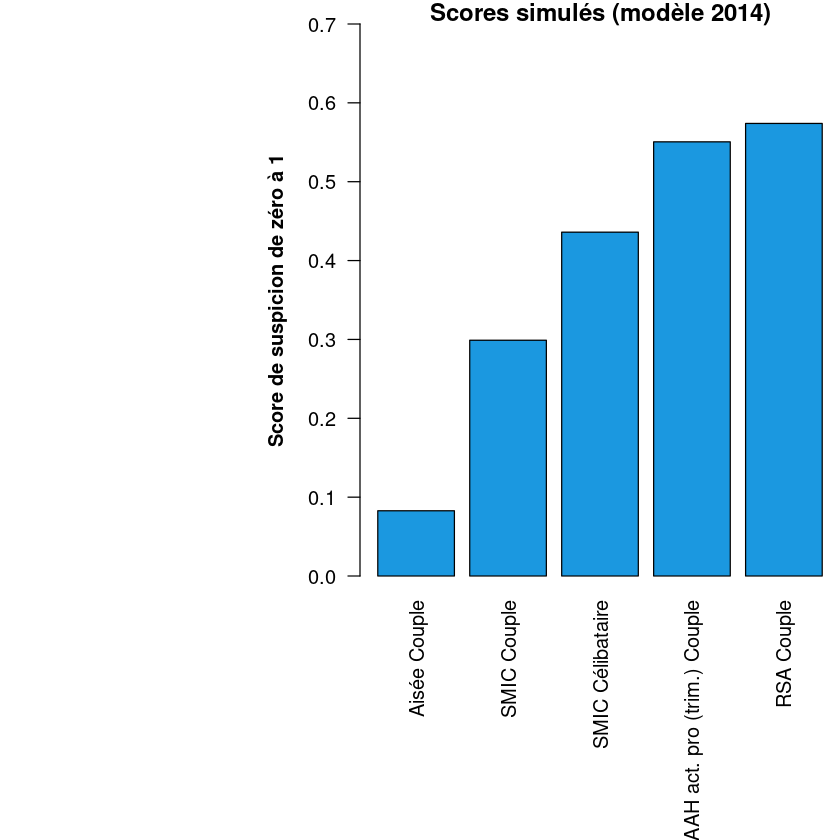

In [51]:
# Graph

fam_riche
fam_smic
parent_celib_smic
fam_ms
parent_isolé_aah
values <- c(fam_riche, fam_smic,parent_celib_smic, aah_couple_travail, fam_ms)                 # Create values for barchart

labels <- c(
    "Aisée Couple", 
    "SMIC Couple", 
    "SMIC Célibataire", 
    "AAH act. pro (trim.) Couple",
    "RSA Couple" 
)

par(mar=c(11, 15, 1, 0))

# Barchart with colored bars
barplot(values, 
        col = "#1b98e0", 
        names.arg=labels,
        las=2, 
        ylim= c(0,0.7),
        #col = rainbow(4)
)

title(
    main="Scores simulés (modèle 2014)",
    xlab="",
    ylab = "Score de suspicion de zéro à 1",
    font.lab = 2
)

dev.print(device = png, file = "export.png", width = 600)